# SVM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
train = pd.read_csv("../data/thorax_and_wing_mdi_train.csv")
test = pd.read_csv("../data/thorax_and_wing_mdi_test.csv")

predictors = [c for c in train.columns if c != "Species"]

X_train, y_train = train[predictors].to_numpy(), train["Species"].to_numpy()
X_test, y_test = test[predictors].to_numpy(), test["Species"].to_numpy()

print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)

Train dataset: (1211, 14) (1211,)
Test dataset: (519, 14) (519,)


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

rbf_parameters = {"svc__C": 1 / np.arange(0.1, 5.1, 0.1)}
poly_parameters = rbf_parameters | {"svc__degree": (1, 2, 3, 4)}
clf_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
clf_poly = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='poly'))
grid_search_rbf = GridSearchCV(clf_rbf, rbf_parameters)
grid_search_poly = GridSearchCV(clf_poly, poly_parameters)
grid_search_rbf.fit(X_train, y_train)
grid_search_poly.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(gamma='auto', kernel='poly'))]),
             param_grid={'svc__C': array([10.        ,  5.        ,  3.33333333,  2.5       ,  2.        ,
        1.66666667,  1.42857143,  1.25      ,  1.11111111,  1.        ,
        0.90909091,  0.83333333,  0.76923077,  0.71428571,  0.66666667,
        0.625     ,  0.58823529,  0.55555556,  0.52631579,  0.5       ,
        0.47619048,  0.45454545,  0.43478261,  0.41666667,  0.4       ,
        0.38461538,  0.37037037,  0.35714286,  0.34482759,  0.33333333,
        0.32258065,  0.3125    ,  0.3030303 ,  0.29411765,  0.28571429,
        0.27777778,  0.27027027,  0.26315789,  0.25641026,  0.25      ,
        0.24390244,  0.23809524,  0.23255814,  0.22727273,  0.22222222,
        0.2173913 ,  0.21276596,  0.20833333,  0.20408163,  0.2       ]),
                         'svc__degree': (1, 2, 3, 4)})

In [4]:
print("Best params       :", grid_search_rbf.best_params_)
print("Best mean CV score:", grid_search_rbf.best_score_)
print("Best params       :", grid_search_poly.best_params_)
print("Best mean CV score:", grid_search_poly.best_score_)

Best params       : {'svc__C': 5.0}
Best mean CV score: 0.8274495799748325
Best params       : {'svc__C': 5.0, 'svc__degree': 1}
Best mean CV score: 0.8150188756249361


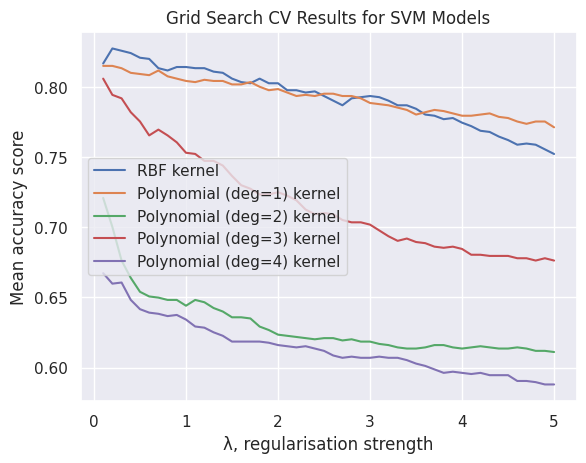

In [5]:
rbf_scores = grid_search_rbf.cv_results_["mean_test_score"]
lambda_values = 1 / grid_search_rbf.cv_results_["param_svc__C"].data

fig, ax = plt.subplots()
ax.plot(lambda_values, rbf_scores, label="RBF kernel")
for i, deg in enumerate(poly_parameters["svc__degree"]):
    poly_scores = grid_search_poly.cv_results_["mean_test_score"][i::4]
    ax.plot(lambda_values, poly_scores, label=f"Polynomial (deg={deg}) kernel")
ax.set_title("Grid Search CV Results for SVM Models")
ax.set_xlabel("λ, regularisation strength")
ax.set_ylabel("Mean accuracy score")
plt.legend()
plt.savefig("../fig/grid_search_cv_svm.png")
plt.show()

In [6]:
clf_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto', C=5))
clf_poly = make_pipeline(StandardScaler(), SVC(gamma='auto', C=5, kernel='poly', degree=1))
clf_rbf.fit(X_train, y_train)
clf_poly.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, degree=1, gamma='auto', kernel='poly'))])

RBF kernel
Training accuracy: 0.886
Test accuracy    : 0.821
Polynomial (deg=1) kernel
Training accuracy: 0.824
Test accuracy    : 0.782


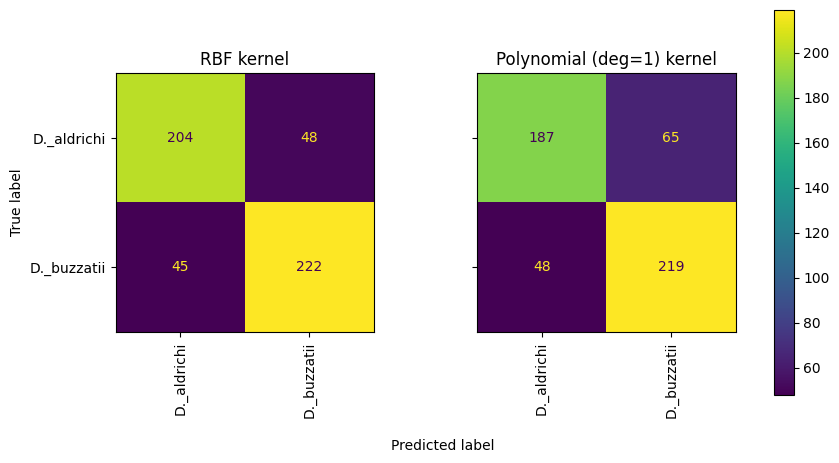

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib

matplotlib.rc_file_defaults()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
titles = ("RBF kernel", "Polynomial (deg=1) kernel")
for i, clf in enumerate((clf_rbf, clf_poly)):
    print(titles[i])
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    print("Training accuracy:", round(accuracy_score(y_train, train_preds), 3))
    print("Test accuracy    :", round(accuracy_score(y_test, test_preds), 3))

    cm = confusion_matrix(y_test, test_preds, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(ax=ax[i], xticks_rotation=90)
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("")
    if i != 0:
        disp.ax_.set_ylabel("")
plt.subplots_adjust(wspace=0.40, hspace=0.1)
fig.text(0.4, 0, 'Predicted label', ha='left')
fig.colorbar(disp.im_, ax=ax)
plt.savefig("../fig/cm_svm.png")
plt.show()